Análisis de datos en salud
============================

Unidad 4 - Parte práctica
-----------------------------------------------------


In [ ]:
# Montamos la unidad Drive para acceder a los archivos de Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Especificamos la ruta hasta la carpeta donde tenemos los archivos de la Unidad 4
%cd /content/drive/MyDrive/Colab_Notebooks/Analisis_datos_salud/Unidad4


Mounted at /content/drive
/content/drive/MyDrive/Colab_Notebooks/Analisis_datos_salud/Unidad4


## Datos de salud mental

El dataset `mental_health.csv` es una muestra de `The Mental Health Corpus`, una colección de textos relacionados con personas que sufren de ansiedad, depresión y otros problemas de salud mental. Consta de dos columnas: una que contiene los comentarios, y otra que contiene etiquetas que indican si los comentarios se consideran tóxicos o no.

Este dataset puede ser utilizado en muchos ámbitos, como análisis de sentimientos, detección de lenguaje tóxico y análisis de lenguaje relacionado con la salud mental. Estos datos pueden ser útiles para investigadores, profesionales de la salud mental y otras personas interesadas en comprender el lenguaje y el sentimiento que rodea los problemas de salud mental.


### Ejercicio 1

a) Primero de todo vamos a explorar un poco el dataset. Carga los datos y muestra su tamaño y el nombre de las columnas. Muestra también por pantalla las 5 primeras filas.

b) ¿Hay algún valor perdido (*missing*) (NaN) o fila duplicada en el dataset? Si los hay, aplica la corrección que te parezca más apropiada. **Razona tu respuesta.**

c) En la variable `label` tenemos información sobre el sentimiento de los tweets: 1 es un sentimiento negativo y 0, positivo. ¿Qué porcentaje hay de cada categoría? ¿Es un dataset balanceado?

In [ ]:
#a)

# Importamos las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import re
import string
from wordcloud import WordCloud
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


# Cargamos el archivo csv en un DataFrame
mental_df = pd.read_csv("data/mental_health.csv", sep=",")

# Mostramos el tamaño del df
print("Tamaño df:\n", mental_df.shape)

# Mostramos el nombre de las columnas
print("Columnas del df:\n", mental_df.columns)

# Visualizamos las 5 primeras filas con el comando head()
mental_df.head()

Tamaño df:
 (27977, 2)
Columnas del df:
 Index(['text', 'label'], dtype='object')


,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1


In [ ]:
# Mostramos el tipo de las variables
print(mental_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27977 entries, 0 to 27976
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    27977 non-null  object
 1   label   27977 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 437.3+ KB
None


In [ ]:
#b) Gestión de duplicados y NaNs

#Miramos si hay duplicados
print("Filas duplicadas:", mental_df.duplicated().sum())

# Hay filas duplicadas!

# Eliminamos las filas duplicadas
mental_df.drop_duplicates(inplace=True)

#Miramos si hay duplicados de nuevo
print("Comprobamos las filas duplicadas:", mental_df.duplicated().sum())

Filas duplicadas: 5
Comprobamos las filas duplicadas: 0


In [ ]:
# No hay valores nulos en el df
mental_df.isna().sum()

text     0
label    0
dtype: int64

In [ ]:
# c) Estudiamos la variable label
# Ahora estudiamos la poporción de la clase label
print("Proporción de personas según el tipo de estado:")
print(mental_df['label'].value_counts(normalize=True),"\n")

# ¡Tenemos un dataset balanceado!

Proporción de personas según el tipo de estado:
label
0    0.505291
1    0.494709
Name: proportion, dtype: float64 



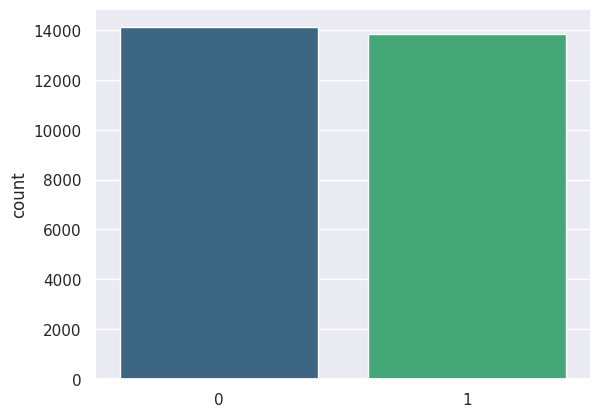

In [ ]:
# Mostramos la distribución de forma visual

# Creamos un gráfico de barras
sns.barplot(x = mental_df['label'].unique(), y = mental_df['label'].value_counts(), palette= 'viridis')
plt.show()

In [ ]:
# Exploramos las variables
mental_df.head(3)

,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0


Para enriquecer el dataset, vamos a crear nuevas variables a partir del texto de los tweets.

In [ ]:
# Creamos una variable con la información del número de palabras por tweet
mental_df['Total Words'] = mental_df['text'].apply(lambda x: len(x.split()))

# Creamos una función para contar el número de caracteres
def count_total_words(text):
    char = 0
    for word in text.split():
        char += len(word)
    return char

# Aplicamos la función a todos los tweets
mental_df['Total Chars'] = mental_df["text"].apply(count_total_words)

In [ ]:
# Exploramos las variables
mental_df.head(3)

,text,label,Total Words,Total Chars
0,dear american teens question dutch person hear...,0,23,112
1,nothing look forward lifei dont many reasons k...,1,20,98
2,music recommendations im looking expand playli...,0,64,387


### Ejercicio 2

Como ya hemos visto en teoría, si queremos usar la información de textos tenemos que realizar un preproceso previo.

Los pasos que vamos a realizar son los siguientes:

- Pasar todo el texto a minúsculas.
- Eliminar las URLs (https, www).
- Eliminar signos de puntuación.
- Eliminar *stop words*
- Proceso de stemming

**Nota**: Para identificar y eliminar las URLs, podéis usar la función siguiente:

In [ ]:
def remove_url(text):
    re_url = re.compile('https?://\S+|www\.\S+')
    return re_url.sub('', text)

In [ ]:
# 1) Pasar texto a minúsculas

# Creamos una función que convierte el texto el minúsculas
def convert_lowercase(text):
    text = text.lower()
    return text

# Aplicamos esta función a nuestros datos
mental_df['text'] = mental_df['text'].apply(convert_lowercase)

In [ ]:
# 2) Eliminar URLs

# Creamos una función que elimina la parte del texto referente a las URLs
def remove_url(text):
    re_url = re.compile('https?://\S+|www\.\S+')
    return re_url.sub('', text)

# Aplicamos esta función a nuestros datos
mental_df['text'] = mental_df['text'].apply(remove_url)

In [ ]:
# 3) Eliminar signos de puntación

# Seleccionamos los signpos de puntuación que queremos eliminar
exclude = string.punctuation
print('Signos de puntuación:', exclude)

# Creamos una función que elimina los signos de la lista exclude
def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))

# Aplicamos esta función a nuestros datos
mental_df['text'] = mental_df['text'].apply(remove_punc)

Signos de puntuación: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [ ]:
# 4) Eliminar stop words

# Tenemos que descargar las stopwords de NLTK y punkt
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# Creamos una función que:
# 1) Tokaniza el texto
# 2) Si los elementos no son stop words, los añade a una nueva lista
# 3) Se concantenan los elementos de la lista separándolos por un espacio
def remove_stopwords(text):
    new_list = []
    words = word_tokenize(text)
    stopwrds = stopwords.words('english')
    for word in words:
        if word not in stopwrds:
            new_list.append(word)
    return ' '.join(new_list)

# Aplicamos esta función a nuestros datos
mental_df['text'] = mental_df['text'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# 5) Proceso de Stemming

# Usamos la función SnowballStemmer para aplicar el stemming
# a las palabras del texto. Por este motivo, se tienen que tokenizar otra vez
def perform_stemming(text):
    stemmer = SnowballStemmer('english')
    new_list = []
    words = word_tokenize(text)
    for word in words:
        new_list.append(stemmer.stem(word))

    return " ".join(new_list)

# Aplicamos esta función a nuestros datos
mental_df['text'] = mental_df['text'].apply(perform_stemming)

In [ ]:
# Mostramos las primeras filas del dataset preprocesado
mental_df.head()

,text,label,Total Words,Total Chars
0,dear american teen question dutch person heard...,0,23,112
1,noth look forward lifei dont mani reason keep ...,1,20,98
2,music recommend im look expand playlist usual ...,0,64,387
3,im done tri feel betterth reason im still aliv...,1,100,493
4,worri year old girl subject domest physicalmen...,1,311,1819


### Ejercicio 3

Ahora vamos a mostrar las palabras más frecuentes según la clase de label. Para esto, se usará una visualización llamada **Nube de palabras** (*World Cloud*).

a) Para generar la nube de palabras, tenemos que juntar todas las palabras en un único string. Crea un único string que contenga las palabras de la columna text de todas las filas separadas por un espacio (" "). Puedes usar la función `join`. Crea un texto para las filas con valor de label 0, y con las filas con valor de label 1.

b) A continuación, usa la función WordCloud de la librería wordcloud, para crear la nube de palabras. Especifica un máximo de 500 palabras para que no salgan demasiadas. Podéis consultar el [repositorio de la librería](https://github.com/amueller/word_cloud/blob/main/examples/simple.py) para ver ejemplos de como usar la función WordCloud.

La estructura a seguir es la siguiente:

`wordcloud = WordCloud().generate(text)`

`plt.imshow(wordcloud, interpolation='bilinear')`

`plt.axis("off")`

Muestra la nube de palabras para las dos clases de label.

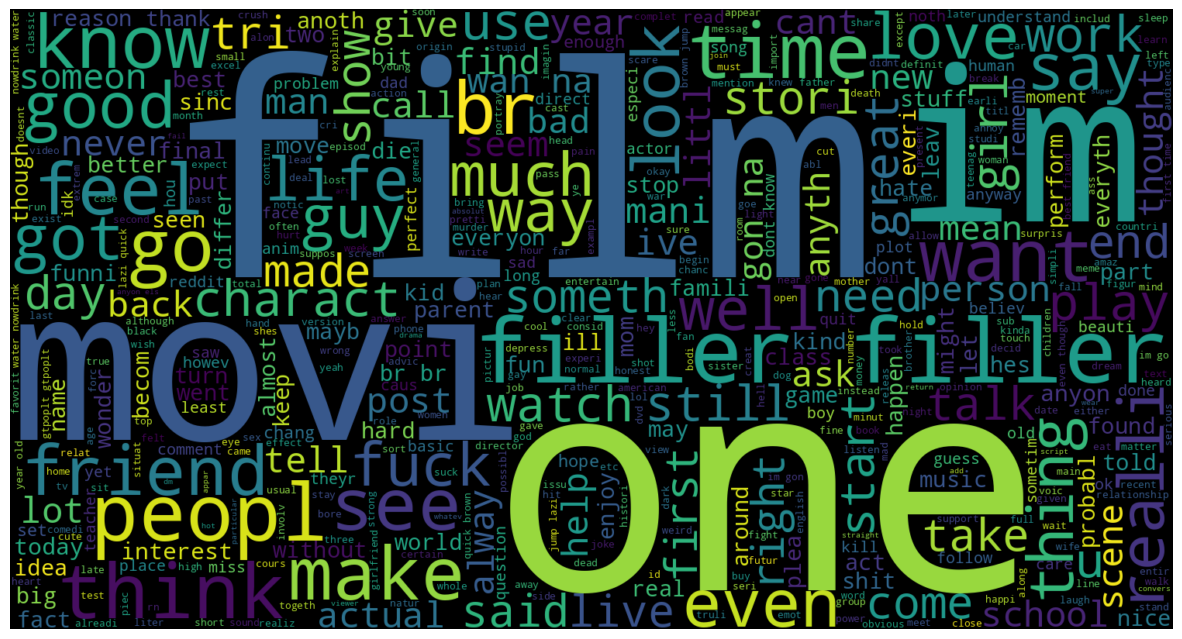

In [ ]:
# Word Cloud con label 0

# Vamos primero a juntar todos los textos que tienen label 0
text0 = " ".join(mental_df[mental_df['label'] == 0]['text'])

# Ahora vamos a usar la función WordCloud para mostrar gráficamente las palabras que aparecen más en el texto
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text0)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

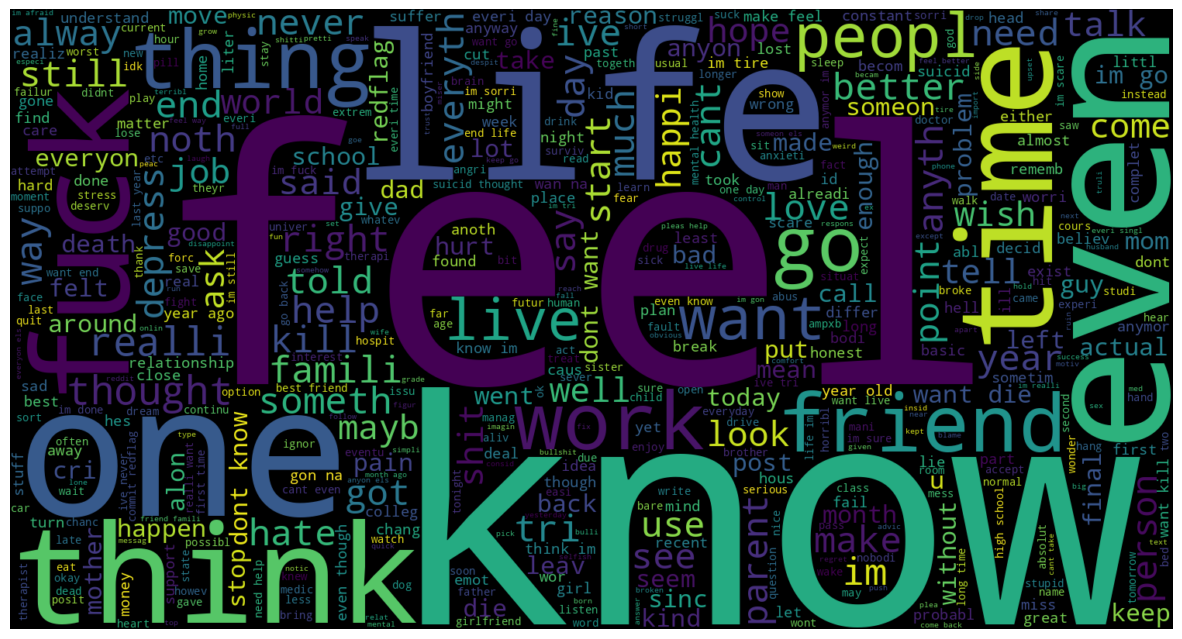

In [ ]:
# Word Cloud con label 1

# Vamos primero a juntar todos los textos que tienen label 1
text1 = " ".join(mental_df[mental_df['label'] == 1]['text'])

# Ahora vamos a usar la función WordCloud para mostrar gráficamente las palabras que aparecen más en el texto
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text1)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Ejercicio 4

En este ejercicio, vamos a crear un modelo de clasificación para ayudar especialistas de la salud a identificar correctamente personas que pueden estar pasando por una situación de complicada que puede a la larga afectar a su salud mental a través del sentimiento de los tweets que escriben.

a) Aplica la transformación de TF-IDF para representar el texto preprocesado en forma de vector. Usa la función `TfidfVectorizer`que hemos visto en teoría con un máximo de 2500 características (en la opción max_features). Podéis consultar la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) para tener más información.

b) Separa los datos en un conjunto de train y de test, con un porcentaje de 70%-30%. El conjunto de train se usará para entrenar los datos y el conjunto de test, para validar los resultados del modelo.

c) Usa un modelo de [regresión logística](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) para predecir la clase label y muestra las métricas del modelo (accuracy, precision, recall, F2). Muestra también la matriz de confusión para ver como se distribuyen los resultados.

In [ ]:
# Queremos clasificar los tweets según el sentimiento (positivo o negativo)
# Como tenemos la información de las clases (label) es un problema de clasificación supervisado

# Primero de todo, tenemos que preparar los datos
# 1) Aplicamos la técnica de TFID para representar el texto en forma de vector
# 2) Separamos datos en dataset de train y test

# Inicializamos la transformación de TfidfVectorizer
tfidf = TfidfVectorizer(max_features= 2500)

# Aplicamos la transformación a los datos
# Guardamos los datos transformados en un nuevo array
# La variable del modelo será el texto preprocesado
X = tfidf.fit_transform(mental_df["text"]).toarray()

# La variable a predecir es label (0 o 1)
y = mental_df['label'].values

In [ ]:
# Separamos el dataset en 70% train y 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42, stratify = y)

In [ ]:
# Ahora vamos a usar un algoritmo de regresión logística (LR) para predecir la clase

# Inicializamos el modelo de LR
lr = LogisticRegression()

# Entranamos el modelo con los datos de train
lr.fit(X_train, y_train)

# Predecimos en el dataset de test
y_pred = lr.predict(X_test)

# Calculamos las métricas básicas
accuracy = round(accuracy_score(y_test, y_pred), 3)
precision = round(precision_score(y_test, y_pred), 3)
recall = round(recall_score(y_test, y_pred), 3)

# Mostramos por pantalla las métricas
print(f'Accuracy del modelo: {accuracy}')
print(f'Precisión del modelo: {precision}')
print(f'Recall del modelo: {recall}')

Accuracy del modelo: 0.917
Precisión del modelo: 0.928
Recall del modelo: 0.903


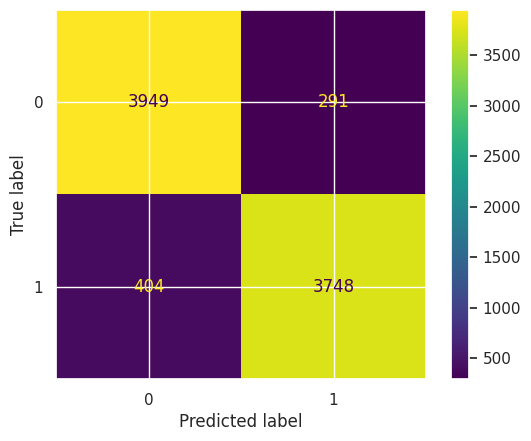

In [ ]:
# Cargamos funciones para calcular y mostrar la matriz de confusión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=lr.classes_)

# La visualizamos con la función ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lr.classes_)
disp.plot()
plt.show()